In [1]:
# 데이터 준비

import pandas as pd

# 데이터 불러오기
data = pd.read_csv('abalone.csv')

# 'id' 열 제거
data = data.drop(columns=['id'])

# 'Sex' 열을 수치형으로 변환, 사실 원핫인코딩이 좀 더 성능에 좋을 거라고 들었는데 이걸로도 해보겠다.
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})


In [2]:
# 훈련 데이터와 테스트 데이터로 분류하기

from sklearn.model_selection import train_test_split

X = data.drop('Rings', axis=1)  # 특성
y = data['Rings']  # 레이블

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# LSTM 모델 구축하기

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 데이터 형태 변환 (LSTM 입력 형태에 맞게)
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# 모델 정의
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # 회귀 문제로 가정

model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\tyra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# 모델 훈련

model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 103.8343
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.1795
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.9031
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.6063
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.8880
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3591
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.7253
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 11.0231
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3433
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2001
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 9.2646
Epoch 12/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 8.1390
Epoch 13/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4649
Epoch 14/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 8.0940
Epoch 15/100
105/105 ━━━━━

In [5]:
# 모델 성능 평가

y_pred = model.predict(X_test)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [8]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# 예측 결과와 실제 값을 사용하여 성능 평가
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Mean Absolute Error: 1.6153112273467214
R² Score: 0.5370021625680317


### 차이가 1.615..로 Rings의 범위가 넓은 것치고 괜찮아 보인다.
### 그럼에도 좀 더 효과를 내기 위해 데이터 스케일링, LSTM 층을 두 개 추가, 드롭아웃을 추가, EarlyStopping 콜백을 추가해보도록 하겠다.

In [9]:
# 데이터 준비
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('abalone.csv')

# 'id' 열 제거
data = data.drop(columns=['id'])

# 'Sex' 열을 수치형으로 변환
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# 훈련 데이터와 테스트 데이터로 분류하기
X = data.drop('Rings', axis=1)  # 특성
y = data['Rings']  # 레이블

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 데이터 형태 변환 (LSTM 입력 형태에 맞게)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 모델 정의
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # 회귀 문제로 가정

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 훈련
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# 모델 성능 평가
y_pred = model.predict(X_test)

# 예측 결과와 실제 값을 사용하여 성능 평가
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Epoch 1/100


C:\Users\tyra\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 107.2585 - val_loss: 60.6104
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.8365 - val_loss: 17.9814
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.0135 - val_loss: 9.7069
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9606 - val_loss: 7.1403
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6525 - val_loss: 5.8086
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2100 - val_loss: 5.2378
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1269 - val_loss: 4.8549
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0450 - val_loss: 4.6733
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6902 - val_loss: 4.6216
Epoch 10/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9916 - val_loss: 4.4406
Epoch 11/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7523 - val_loss: 4.4428
Epoch 12/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0195 -

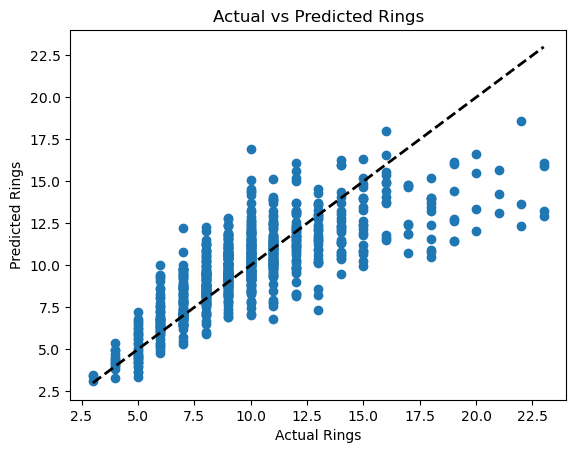

In [10]:

# 예측 결과 시각화
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title('Actual vs Predicted Rings')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


### Mean Absolute Error: 1.4923326541362196
###  R² Score: 0.5898099770698153
### 로 mae가 0.1이상 줄어 유의미한 성과가 있었다.